In [1]:
%matplotlib inline
import pylab as plt
import numpy as np
import galsim
from tractor import *
from tractor.sersic import *
import tractor
print(tractor.sersic.__file__)

/Users/dstn/tractor/tractor/sersic.py


In [2]:
#gal = SersicGalaxy(PixPos(50., 50.), Flux(100.), EllipseE(15.0, 0.2, 0.0), SersicIndex(1.0))
gal = SersicGalaxy(PixPos(50., 50.), Flux(100.), EllipseE(15.0, 0.0, 0.0), SersicIndex(1.0))

In [3]:
H,W = 100,100

xx,yy = np.meshgrid(np.arange(25),np.arange(25))
psf_sigma = 2.
psf_img = np.exp(-0.5 * ((xx-12)**2 + (yy-12)**2) / psf_sigma**2)
psf_img /= np.sum(psf_img)
gausspsf = GaussianMixturePSF(1., 0., 0., psf_sigma**2, psf_sigma**2, 0.)
pixpsf = PixelizedPSF(psf_img)
hpsf = HybridPixelizedPSF(pixpsf, gauss=gausspsf)

img = Image(data=np.zeros((H,W)), inverr=np.ones((H,W)), psf=hpsf)
tim = img

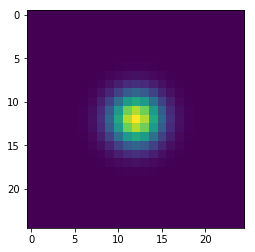

In [4]:
plt.imshow(psf_img);

In [5]:
tr = Tractor([img], [gal])

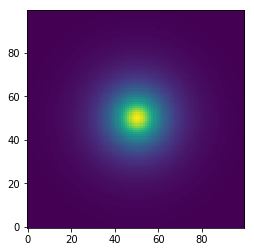

In [6]:
mod = tr.getModelImage(0)
plt.imshow(mod, interpolation='nearest', origin='lower');

In [7]:
gal.freezeAllBut('sersicindex')

In [8]:
SersicIndex.stepsize = 0.001

/Users/dstn/TheTractor/code/optimize_sersic.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.7/site-packages/ipykernel

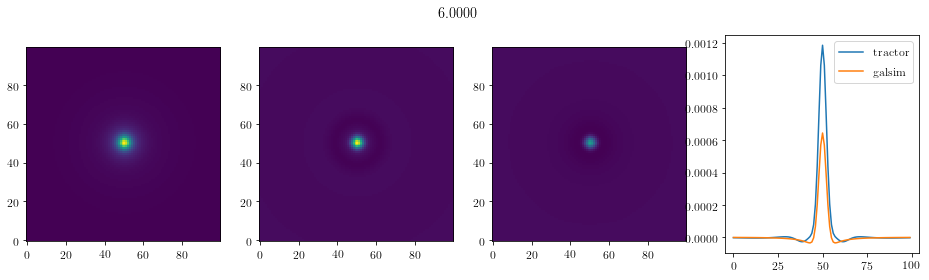

In [9]:
from optimize_sersic import ser_model
re = 15.0
cx = 50
cy = 50
rr = (np.arange(W)-cx)/re
#serstep = 0.01
serstep = SersicIndex.stepsize
from scipy.ndimage.filters import gaussian_filter

gal = SersicGalaxy(PixPos(50., 50.), Flux(1.), EllipseE(re, 0.0, 0.0), SersicIndex(1.0))
gal.freezeAllBut('sersicindex')
tr = Tractor([img], [gal])

import galsim

ss = SersicIndex.stepsize

#sersics = np.linspace(2.999, 6.0, 3)
#sersics = [2.999]
#sersics = [0.395, 0.399, 0.400]

#sersics = [0.3, 0.35, 0.4-ss/2., 0.4, 0.4+ss/2., 0.405, 0.41, 0.5-ss/2, 0.5,]
#sersics = [0.55-ss, 0.55, 0.55+ss, 0.555, 0.56-ss, 0.56]
#sersics = [0.599, 0.6, 0.605, 0.609, 0.61,
#           0.69, 0.699, 0.7, 0.705, 0.709, 0.71,
#          ]
sersics = [#0.790, 0.799, 0.800, 0.805, 0.809, 0.81,
          #1.499, 1.500, 1.505, 1.509, 1.510, 1.54]
            6.0]
for i,si in enumerate(sersics):
    #### This isn't right (need 2d conv)
    #s1 = ser_model(np.abs(rr), si-serstep/2.)
    #s2 = ser_model(np.abs(rr), si+serstep/2.)
    #s1 = gaussian_filter(s1, np.sqrt(2.))
    #s2 = gaussian_filter(s2, np.sqrt(2.))
    #ds = (s2 - s1) / serstep
    plt.figure(num=i+1, figsize=(16,4))

    pixel_scale = 1.0
    #gs_psf = galsim.Gaussian(flux=1., sigma=np.sqrt(2.))

    draw_args = dict(scale=pixel_scale)
    pim = galsim.Image(psf_img)
    gs_psf = galsim.InterpolatedImage(pim, scale=pixel_scale)
    draw_args.update(method='no_pixel')
    
    #gs_gal = galsim.Sersic(si-serstep/2., half_light_radius=re)
    gs_gal = galsim.Sersic(si, half_light_radius=re)
    gs_gal = gs_gal.shift(0.5, 0.5)
    gs_final = galsim.Convolve([gs_gal, gs_psf])
    gs_image = gs_final.drawImage(**draw_args)
    bb = gs_image.bounds
    #print('bb', bb)
    gs_image = gs_image.array
    iy,ix = np.unravel_index(np.argmax(gs_image), gs_image.shape)
    #print('max', ix,iy)
    gs_image = gs_image[iy-cy:, ix-cx:][:H,:W]

    gs_gal = galsim.Sersic(si+serstep, half_light_radius=re)
    gs_gal = gs_gal.shift(0.5, 0.5)
    gs_final = galsim.Convolve([gs_gal, gs_psf])
    gs_image2 = gs_final.drawImage(**draw_args)
    bb = gs_image2.bounds
    #print('bb2', bb)
    gs_image2 = gs_image2.array
    iy,ix = np.unravel_index(np.argmax(gs_image2), gs_image2.shape)
    #print('max', ix,iy)
    gs_image2 = gs_image2[iy-cy:, ix-cx:][:H,:W]

    
    ds = (gs_image2 - gs_image) / (serstep)
    
    gal.sersicindex.setValue(si)
    derivs = gal.getParamDerivatives(img)
    assert(len(derivs) == 1)
    deriv = derivs[0]
    dd = np.zeros((H,W))
    deriv.addTo(dd)
    #color = cm(i/Nsteps)
    plt.clf()
    plt.subplot(1,4,1)
    plt.imshow(tr.getModelImage(0), interpolation='nearest', origin='lower')

    mn = min(np.min(dd), np.min(ds))
    mx = max(np.max(dd), np.max(ds))
    da = dict(interpolation='nearest', origin='lower', vmin=mn, vmax=mx)
    plt.subplot(1,4,2)
    plt.imshow(dd, **da)
    plt.subplot(1,4,3)
    plt.imshow(ds, **da)

    plt.subplot(1,4,4)
    d1 = dd[:,50]
    d2 = ds[:,50]
    #scale = max(d1) / max(d2)
    scale = 1.0
    plt.plot(d1, label='tractor')
    plt.plot(d2 * scale, label='galsim')
    plt.legend()
    #plt.xlim(45,55)
    #scale = max(dd[:,50])/max(ds)
    #plt.plot(dd[:,50], label='%.2f'%si)
    #plt.plot(ds * scale)
    #plt.ylim(-0.1, 0.5)
    plt.suptitle('%0.4f'%si)
    plt.show()
#plt.legend();


In [ ]:
re = 15.0
W,H = 100,100

#sersics = np.linspace(0.4, 0.6, 2)
sersics = [5.7] #0.395]

for i,si in enumerate(sersics):

    pixel_scale = 1.0
    draw_args = dict(scale=pixel_scale)

    #gs_psf = galsim.Gaussian(flux=1., sigma=np.sqrt(2.))
    pim = galsim.Image(psf_img)
    gs_psf = galsim.InterpolatedImage(pim, scale=pixel_scale)
    draw_args.update(method='no_pixel')

    gs_gal = galsim.Sersic(si, half_light_radius=re)
    gs_gal = gs_gal.shift(0.5, 0.5)
    gs_final = galsim.Convolve([gs_gal, gs_psf])
    gs_image = gs_final.drawImage(**draw_args)
    gs_image = gs_image.array
    iy,ix = np.unravel_index(np.argmax(gs_image), gs_image.shape)
    gs_image = gs_image[iy-H//2:, ix-W//2:][:H,:W]

    noise_sigma = 1e-4
    
    gs_image += np.random.normal(size=(H,W), scale=noise_sigma)
    
    gal = SersicGalaxy(PixPos(50., 50.), Flux(100.), EllipseE(15.0, 0.0, 0.0), SersicIndex(1.0))

    tim.setImage(gs_image)
    tr = Tractor([tim], [gal])
    tr.freezeParam('images')
    tr.optimize_loop()

    print(gal)

    mod = tr.getModelImage(0)
    plt.figure(num=i+1, figsize=(12,4))
    plt.subplot(1,3,1)
    ima = dict(interpolation='nearest', origin='lower')
    plt.imshow(gs_image, **ima)
    plt.title('%0.3f' % si)

    plt.subplot(1,3,2)
    plt.imshow(mod+ np.random.normal(size=(H,W), scale=noise_sigma), **ima)
    plt.title('%0.3f' % gal.sersicindex.getValue())
    plt.subplot(1,3,3)
    plt.imshow(gs_image - mod, vmin=-1e-3, vmax=+1e-3, **ima)
    #plt.suptitle('%0.2f' % si)
    plt.show()


In [ ]:
re = 15.0
W,H = 100,100

sersics = np.linspace(0.3, 5.9, 11)
#sersics = [0.35]

true_ser = []
fit_ser = []
fit_dser = []

fit_allparams = []
fit_alld = []

pixel_scale = 1.0
draw_args = dict(scale=pixel_scale)

noise_sigma = 1.

#psf_sigma = 2.
#psf=GaussianMixturePSF(1., 0., 0., psf_sigma**2, psf_sigma**2, 0.))
psf = hpsf
pim = galsim.Image(psf_img)
#gs_psf = galsim.Gaussian(flux=1., sigma=psf_sigma)
gs_psf = galsim.InterpolatedImage(pim, scale=pixel_scale)
draw_args.update(method='no_pixel')

img = Image(data=np.zeros((H,W)), inverr=np.ones((H,W), np.float32) / noise_sigma, psf=psf)
tim = img

from tractor.constrained_optimizer import ConstrainedOptimizer

allimages = []
allmodels = []

for i,si in enumerate(sersics):
    gs_gal = galsim.Sersic(si, half_light_radius=re)
    gs_gal = gs_gal.shear(galsim.Shear(g1=0.1, g2=0.0))
    gs_gal = gs_gal.shift(0.5, 0.5)
    gs_final = galsim.Convolve([gs_gal, gs_psf])
    gs_image = gs_final.drawImage(**draw_args)
    gs_image = gs_image.array
    iy,ix = np.unravel_index(np.argmax(gs_image), gs_image.shape)
    gs_image = gs_image[iy-H//2:, ix-W//2:][:H,:W]
    #print('Max pixel S/N:', np.max(gs_image) / noise_sigma)

    flux = 1. + 3.*(float(i) / max(1, len(sersics)-1))
    flux *= 10000.
                             
    imgrow = []
    modrow = []
    for j in range(5):
        noisy_image = flux * gs_image + np.random.normal(size=(H,W), scale=noise_sigma)
        imgrow.append(noisy_image)
        
        tim.setImage(noisy_image)

        gal = SersicGalaxy(PixPos(W//2+np.random.normal(), H//2+np.random.normal()),
                           Flux(100.), EllipseE(10., 0.0, 0.0),
                           SersicIndex(2.5))
        tr = Tractor([tim], [gal], optimizer=ConstrainedOptimizer())
        tr.freezeParam('images')
        try:
            tr.optimize_loop(dchisq=0.1, shared_params=False)
            v = tr.optimize(variance=True, just_variance=True, shared_params=False)
        except:
            print('Failed', si)
            import traceback
            traceback.print_exc()
            continue
            
        mod = tr.getModelImage(0)
        modrow.append(mod)
        #print('dp:', np.sqrt(v))
        #print('  variances:', len(v))
        dser = np.sqrt(v[-1])
        print('ser', si, 'trial', j, '->', gal.sersicindex.getValue(), '+-', dser)
        if dser == 0:
            mod = tr.getModelImage(0)
            plt.clf()
            plt.imshow(mod)
            plt.title('ser %.4f' % gal.sersicindex.getValue())
            plt.show()
            derivs = tr.getDerivs()
            for d,name in zip(derivs, tr.getParamNames()):
                if d is None:
                    print('Deriv', name, 'is None')
                    continue
                for di,_ in d:
                    im = np.zeros((H,W))
                    di.addTo(im)
                    plt.imshow(im)
                    plt.title('derivative for %s' % name)
                    plt.show()

            ### HACK FIXME
            continue
        true_ser.append(si)
        fit_ser.append(gal.sersicindex.getValue())
        fit_dser.append(dser)
        
        fit_allparams.append(gal.getParams())
        fit_alld.append(1./np.sqrt(v))
    allimages.append(imgrow)
    allmodels.append(modrow)

plt.plot(true_ser, fit_ser, 'b.')

In [ ]:
allims = np.vstack([np.hstack([img[40:60,40:60] for img in row]) for row in allimages])
allmods = np.vstack([np.hstack([img[40:60,40:60] for img in row]) for row in allmodels])
plt.figure(num=1, figsize=(20,10))
plt.subplot(1,2,1)
ima = dict(interpolation='nearest', origin='lower')
plt.imshow(allims, **ima)
#plt.show()
#plt.figure(num=1, figsize=(10,10))
plt.subplot(1,2,2)
plt.imshow(allmods, **ima)
plt.show()

In [ ]:
plt.figure(num=1, figsize=(8,6), dpi=100)
plt.plot(true_ser, fit_ser, 'b.')
plt.xlabel('True Sersic index (GalSim)')
plt.ylabel('Fit Sersic index (Tractor)')
ax = plt.axis()
plt.plot([0,10],[0,10],'k-', alpha=0.5)
plt.axis(ax);
plt.savefig('serfit.png')

In [ ]:
plt.figure(num=1, figsize=(8,6), dpi=100)

true_ser = np.array(true_ser)
fit_ser = np.array(fit_ser)
fit_dser = np.array(fit_dser)
ts = np.unique(true_ser)

fit_avg = []
fit_davg = []
for s in ts:
    I = np.flatnonzero(true_ser == s)
    fit_avg.append(np.mean(fit_ser[I]))
    fit_davg.append(np.mean(fit_dser[I]))

plt.plot(true_ser, fit_ser - true_ser, 'b.', alpha=0.5)
plt.errorbar(ts, fit_avg - ts, yerr=fit_davg, fmt='o', mfc='none', capsize=5, color='k')
plt.axhline(0., color='k', alpha=0.5)
plt.xlabel('True Sersic index (GalSim)')
plt.ylabel('Sersic Index error: Tractor - GalSim')
yl,yh = plt.ylim()
yy = max(np.abs(yl), np.abs(yh))
plt.ylim(-yy, +yy);
plt.savefig('sererr.png')

In [ ]:
allp = np.array(fit_allparams)
alld = np.array(fit_alld)

In [ ]:
plt.errorbar(allp[:,0], allp[:,1], xerr=np.sqrt(alld[:,0]), yerr=np.sqrt(alld[:,1]), fmt='o')

In [16]:
# Are we consistent with ourselves??  Fit a tractor DeV model with a Sersic.
re = 15.0
W,H = 100,100

sersics = [4.]*5
true_ser = []
fit_ser = []
fit_dser = []
fit_allparams = []
fit_alld = []

pixel_scale = 1.0
draw_args = dict(scale=pixel_scale)

noise_sigma = 1.
psf = hpsf

img = Image(data=np.zeros((H,W)), inverr=np.ones((H,W), np.float32) / noise_sigma, psf=psf)
tim = img

from tractor.constrained_optimizer import ConstrainedOptimizer

allimages = []
allmodels = []

for i,si in enumerate(sersics):

    dev = DevGalaxy(PixPos(W//2, H//2), Flux(10000.), EllipseE(re, 0.1, 0.0))
    tr = Tractor([tim], [dev])
    mod = tr.getModelImage(0)

    imgrow = []
    modrow = []
    for j in range(5):
        noisy_image = mod + np.random.normal(size=(H,W), scale=noise_sigma)
        imgrow.append(noisy_image)

        tim.setImage(noisy_image)

        gal = SersicGalaxy(PixPos(W//2+np.random.normal(), H//2+np.random.normal()),
                           Flux(100.), EllipseE(10., 0.0, 0.0),
                           SersicIndex(2.5))
        tr = Tractor([tim], [gal], optimizer=ConstrainedOptimizer())
        tr.freezeParam('images')
        try:
            tr.optimize_loop(dchisq=0.1, shared_params=False)
            v = tr.optimize(variance=True, just_variance=True, shared_params=False)
        except:
            print('Failed', si)
            import traceback
            traceback.print_exc()
            continue
            
        mod = tr.getModelImage(0)
        modrow.append(mod)
        dser = np.sqrt(v[-1])
        print('ser', si, 'trial', j, '->', gal.sersicindex.getValue(), '+-', dser)
        true_ser.append(si)
        fit_ser.append(gal.sersicindex.getValue())
        fit_dser.append(dser)
        fit_allparams.append(gal.getParams())
        fit_alld.append(1./np.sqrt(v))
    allimages.append(imgrow)
    allmodels.append(modrow)
#plt.plot(true_ser, fit_ser, 'b.')

ser 4.0 trial 0 -> 3.9149680939340947 +- 0.04331132149452204
ser 4.0 trial 1 -> 4.014972827922832 +- 0.03978405584652739
ser 4.0 trial 2 -> 4.04284701956613 +- 0.03999038879375972
ser 4.0 trial 3 -> 4.01597410955413 +- 0.04068652852985583
ser 4.0 trial 4 -> 4.017052825434833 +- 0.04039908943600802
ser 4.0 trial 0 -> 4.153566439305415 +- 0.04223169425127763
ser 4.0 trial 1 -> 4.187703792023277 +- 0.04504030510698538
ser 4.0 trial 2 -> 4.0839077767257175 +- 0.04692889573049544
ser 4.0 trial 3 -> 4.205436054943213 +- 0.04591226431784598
ser 4.0 trial 4 -> 4.221567329596433 +- 0.044318345390513124
ser 4.0 trial 0 -> 3.86528694014224 +- 0.04517740106532359
ser 4.0 trial 1 -> 3.673754183185548 +- 0.05353434241992442
ser 4.0 trial 2 -> 3.7009737655890973 +- 0.04880068137513346
ser 4.0 trial 3 -> 3.7754133652235775 +- 0.048333680297802176
ser 4.0 trial 4 -> 3.8141168311785383 +- 0.0433137114296258
ser 4.0 trial 0 -> 3.839817192546623 +- 0.045509582088644286
ser 4.0 trial 1 -> 3.775949915584600

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x10e638268> (for post_execute):


TimeoutError: LOCKERROR: matplotlib is trying to acquire the lock
    '/Users/dstn/.matplotlib/tex.cache/.matplotlib_lock-*'
and has failed.  This maybe due to any other process holding this
lock.  If you are sure no other matplotlib process is running try
removing these folders and trying again.


TimeoutError: LOCKERROR: matplotlib is trying to acquire the lock
    '/Users/dstn/.matplotlib/tex.cache/.matplotlib_lock-*'
and has failed.  This maybe due to any other process holding this
lock.  If you are sure no other matplotlib process is running try
removing these folders and trying again.


<Figure size 432x288 with 1 Axes>

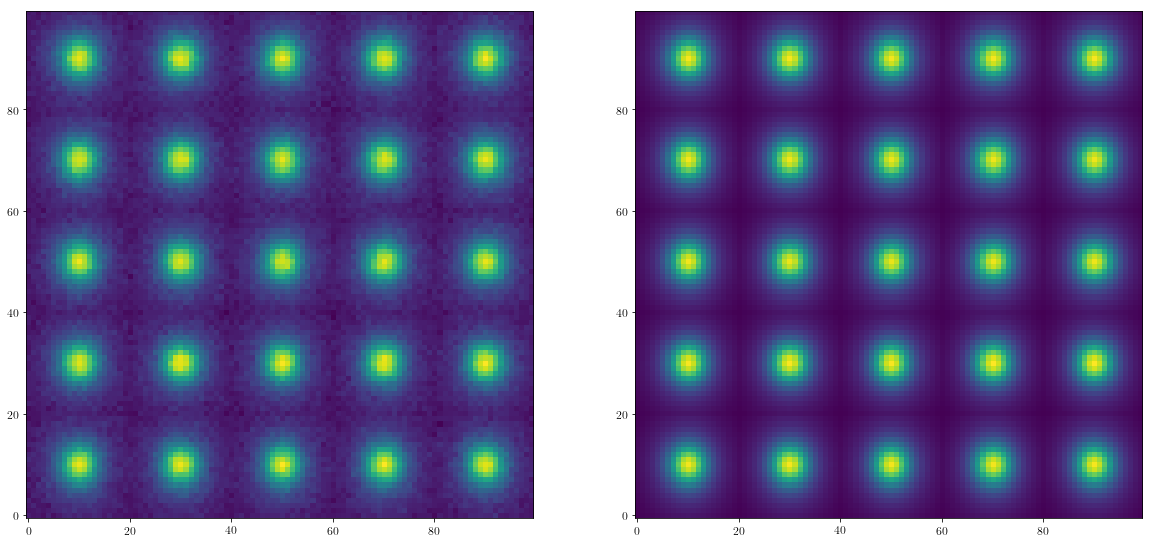

In [17]:
allims = np.vstack([np.hstack([img[40:60,40:60] for img in row]) for row in allimages])
allmods = np.vstack([np.hstack([img[40:60,40:60] for img in row]) for row in allmodels])
plt.figure(num=1, figsize=(20,10))
plt.subplot(1,2,1)
ima = dict(interpolation='nearest', origin='lower')
plt.imshow(allims, **ima)
#plt.show()
#plt.figure(num=1, figsize=(10,10))
plt.subplot(1,2,2)
plt.imshow(allmods, **ima)
plt.show()

3.914699540446328 0.17698992137755054


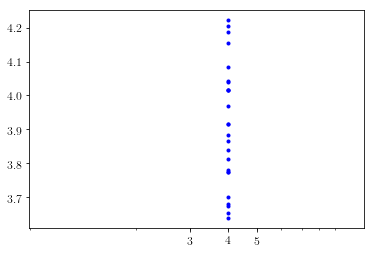

In [26]:
print(np.mean(fit_ser), np.std(fit_ser))
ax1 = plt.gca()
ax1.plot(true_ser, fit_ser, 'b.');
ax1.set_xscale('log')
ax1.set_xticks([3,4,5])
import matplotlib.ticker
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
